# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [201]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [228]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/101.7 MB 1.4 MB/s eta 0:01:13
   ---------------------------------------- 1.0/101.7 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 1.3/101.7 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 1.6/101.7 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 1.8/101.7 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 2.1/101.7 MB 1.3 MB/s eta 0:01:17
    --------------------------------------- 2.4/101.7 MB 1.3 MB/s eta 0:01:17
   - -------------------------------------- 2.6/101.7 MB 1.3 MB/s eta 0:01:17
   - -------------------------------------- 2.9/101.7 MB 1.3 MB/s eta 0:01:17
   - --


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

In [203]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [205]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [206]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [207]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [208]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [209]:
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [210]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

## Split data
- we split data into train dataset and test dataset to prevent data leakage 

In [211]:
train_df , test_df = train_test_split(df, test_size = 0.2 , random_state =42)
train_df = train_df.reset_index(drop= True)
test_df = test_df.reset_index(drop = True)
# Quick check
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (40000, 14)
Test shape: (10000, 14)


In [212]:
train_df['booking_complete'].value_counts()

booking_complete
0    34002
1     5998
Name: count, dtype: int64

In [213]:
X_train = train_df.drop('booking_complete', axis=1)
y_train = train_df['booking_complete']
X_test = test_df.drop('booking_complete', axis=1)
y_test = test_df['booking_complete']

### Convert categorial data into numerical data 

In [214]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

def factorize_columns(X):
    for colname in X.select_dtypes("object"):
        X.loc[:, colname], _ = X[colname].factorize()
    return X


pipeline = Pipeline([
    ('factorize', FunctionTransformer(factorize_columns, validate=False)),
    ('scaler', StandardScaler()),  # Scaling numeric features after factorization
])

In [215]:
# Fit and transform on training data
train_transformed = pipeline.fit_transform(X_train)
train_transformed = pd.DataFrame(train_transformed, columns=X_train.columns)  # Convert back to DataFrame

# Transform the test data in the same way
test_transformed = pipeline.transform(X_test)
test_transformed = pd.DataFrame(test_transformed, columns=X_train.columns)  # Convert back to DataFrame

In [216]:
X_train

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,1,0,0,15,5,13,7,0,0,0,0,1,6.62
1,1,1,0,298,4,9,1,1,1,1,0,0,8.83
2,2,1,0,200,6,5,3,2,2,1,0,0,6.62
3,1,1,0,79,21,11,6,3,3,1,0,0,8.58
4,1,1,0,105,20,6,7,4,2,1,0,1,6.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1,1,0,20,91,11,5,327,4,1,0,1,8.58
39996,1,1,0,65,6,18,3,33,31,1,1,1,7.42
39997,2,0,0,107,5,6,2,266,1,1,0,0,7.57
39998,4,1,0,232,19,8,2,14,9,0,0,0,8.83


In [217]:
X_train.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.591875,84.811150,23.066675,9.067225,3.815400,0.667950,0.295500,0.425850,7.273254
std,1.015670,90.301775,33.533594,5.409990,1.995876,0.470955,0.456273,0.494477,1.498109
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000
25%,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000
50%,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000
75%,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000
max,9.000000,704.000000,773.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000


## Calculate MI Score
to measure how much information a feature gives us about the taret variables 

In [218]:
mi_score = mutual_info_classif(X_train,y_train)
mi_score = pd.Series(mi_score , name = "MI Scores", index = X.columns)
mi_score = mi_score.sort_values(ascending= False)
mi_score

route                    0.053795
booking_origin           0.044475
flight_duration          0.015779
length_of_stay           0.010204
wants_extra_baggage      0.009988
sales_channel            0.006138
wants_preferred_seat     0.004636
num_passengers           0.003557
wants_in_flight_meals    0.003068
trip_type                0.001825
flight_day               0.001496
purchase_lead            0.000000
flight_hour              0.000000
Name: MI Scores, dtype: float64

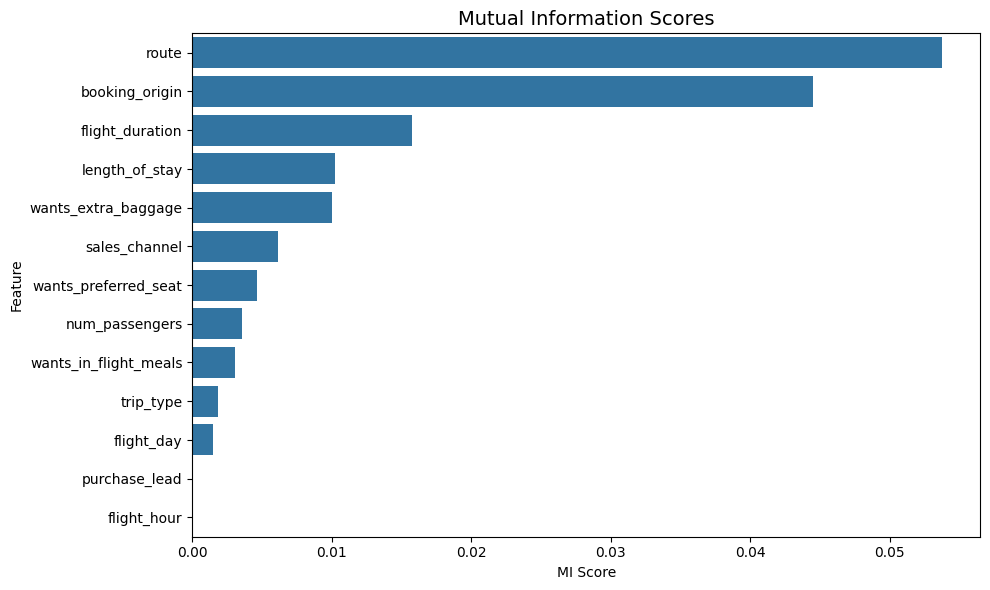

In [219]:

# Assuming mi_scores is a pandas Series like the one you posted
plt.figure(figsize=(10, 6))
sns.barplot(
    x=mi_score.values,
    y=mi_score.index,
)

plt.title("Mutual Information Scores", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


-- from the chart we can see that the most effective features which are dependent on the booking_complete feature are
- Route
- Booking_origin
- Flight Duration
- Length_of_stay
- Wants_extra_baggage
- wants_preferred_seat

## Model 1 : Random forest classifier with most effective features

In [220]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [221]:
selected_features = ['route','booking_origin','flight_duration','length_of_stay','wants_extra_baggage', 'wants_preferred_seat']
# Separate features and target for the training and test sets
x_tran = train_df[selected_features]
y_tran = train_df['booking_complete']
x_tes = test_df[selected_features]
y_tes = test_df['booking_complete']
# Fit the pipeline on the training data and transform it
x_train_transformed = pipeline.fit_transform(x_tran)

# Now, use the same pipeline to transform the test data
x_test_transformed = pipeline.transform(x_tes)

In [222]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_transformed, y_tran)

# Make predictions on the test data
y_pred = rf_model.predict(x_test_transformed)

# Calculate and print the accuracy
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_tes, y_pred)*100}")

Accuracy: 82.45


### Model 2 : Random forest classifier with all features

In [223]:
rf_model2 = RandomForestClassifier()
# Fit the model
rf_model2.fit(X_train, y_train)
y_predict = rf_model2.predict(test_transformed)
print(f"Accuracy: {accuracy_score(y_test, y_predict)*100}")

Accuracy: 74.25


## model 3: XGB classifier

In [224]:
X_train

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,1,0,0,15,5,13,7,0,0,0,0,1,6.62
1,1,1,0,298,4,9,1,1,1,1,0,0,8.83
2,2,1,0,200,6,5,3,2,2,1,0,0,6.62
3,1,1,0,79,21,11,6,3,3,1,0,0,8.58
4,1,1,0,105,20,6,7,4,2,1,0,1,6.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1,1,0,20,91,11,5,327,4,1,0,1,8.58
39996,1,1,0,65,6,18,3,33,31,1,1,1,7.42
39997,2,0,0,107,5,6,2,266,1,1,0,0,7.57
39998,4,1,0,232,19,8,2,14,9,0,0,0,8.83


In [226]:
# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(train_transformed, y_train)

# Make predictions
prediction_xgb = xgb_model.predict(test_transformed)

# Print accuracy
print('ACCURACY: ', accuracy_score(y_test, prediction_xgb) * 100)

ACCURACY:  84.76
